In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import warnings
import pickle
import sys
import json
import neptune

warnings.filterwarnings('ignore')

# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
sys.path.append('../datawrangling')
# import modules
import visualize
import geometry_utils
import dataloader_geo
from maritime_traffic_network import MaritimeTrafficNetwork
import prediction_model_evaluation_metrics as metrics

In [2]:
# path to directory of model
location = 'oslo'
path_format = 'node2node'
filter = 'Last'
directory = '../../models/gretel_prediction_models/'+location+'_small/'+path_format+'/'
prediction_task = 'next_nodes'
n_steps = 10
# load metadata from file
with open(directory+'/metadata_'+prediction_task+str(n_steps)+'.json', 'r') as json_file:
    meta_dict = json.load(json_file)
meta_dict

{'network_name': '202208_waypoints_DP10_HDBSCAN20_oslo_full_UTM',
 'n_points': 2173821,
 'n_nodes': 816,
 'n_edges': 3945,
 'training_dates': "['202206', '202207', '202208']",
 'data_version': '',
 'n_training_paths': 653,
 'node_features': "['n_members', 'speed', 'cog_before', 'cog_after', 'lat', 'lon']",
 'egde_features': "['direction', 'length', 'weight']",
 'path_format': 'node2node',
 'filter': 'Last',
 'lr': 0.0005,
 'loss': 'target_only',
 'n_epochs': 19,
 'target_prediction': 'next',
 'n_walks': 1000,
 'n_start_nodes': 1,
 'n_steps': 10,
 'prediction_task': 'next_nodes',
 'predictions_per_second': 2.121657062746819,
 'model_type': 'Gretel',
 'test_dates': "['202209']",
 'selection_start': 0,
 'selection_end': -1,
 'selection_step': 20,
 'n_test_paths': 820}

In [3]:
# set parameters for prediction
prediction_task = meta_dict['prediction_task']
eval_mode = 'path'
n_start_nodes= meta_dict['n_start_nodes']
n_steps = meta_dict['n_steps']
network_name = meta_dict['network_name']
test_dates = literal_eval(meta_dict['test_dates'])

In [4]:
# load maritime traffic network
network_path = '../../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202208_points_oslo_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 20,
 'clustering_min_cluster_size': 20,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [5]:
# Load test trajectories from file
traj_path_prefix = '../../data/processed/'
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

In [6]:
# load predictions from file
predictions = pd.read_csv(directory+'/predictions_'+prediction_task+str(n_steps)+'.csv')
predictions['ground_truth'] = predictions['ground_truth'].apply(literal_eval)
predictions['prediction'] = predictions['prediction'].apply(literal_eval)

In [7]:
# check if all predictions are valid
for index, row in predictions.iterrows():
    if geometry_utils.is_valid_path(network.G, row['ground_truth']) == False:
        print(row['mmsi'].tolist())

In [8]:
# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)
nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-355
Evaluating 820 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.26 minutes


Percentage of unsuccessful predictions: 0.00%
Mean SSPD: 1389.09m
Median SSPD: 461.84m
Mean choice_accuracy: 0.4341


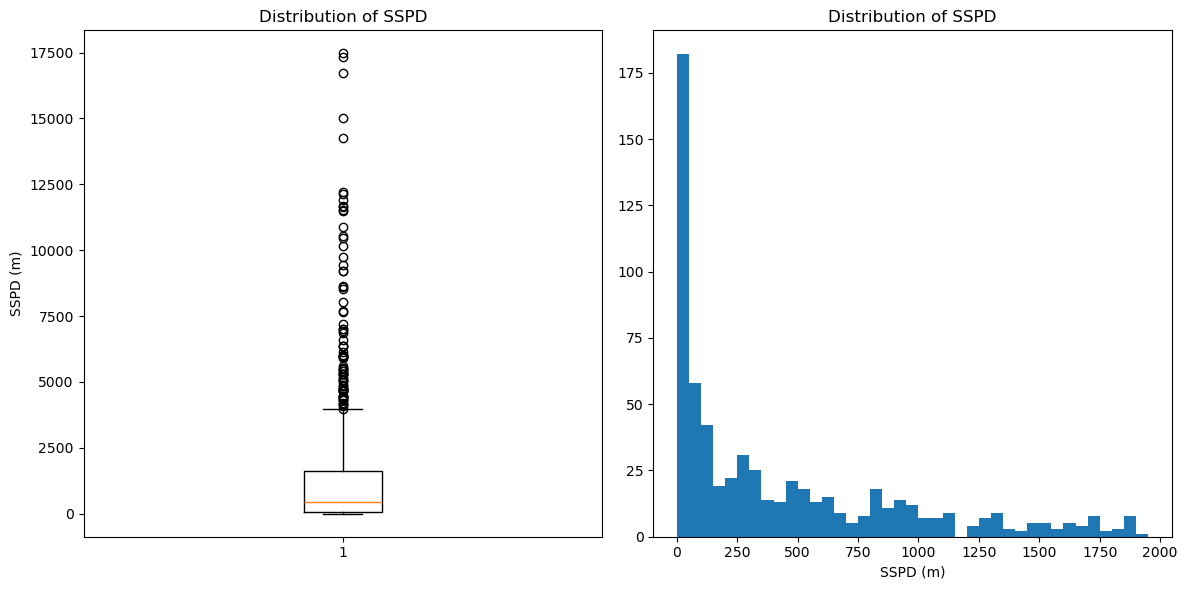

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 42 operations to synchronize with Neptune. Do not kill this process.
All 42 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-355/metadata


In [9]:
'''
run = neptune.init_run(
    project="jandrik91/RoutePredictions",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

# evaluate
evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                             network, n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                                             eval_mode=eval_mode)

nan_mask = evaluation_results.isna().any(axis=1)
failure_rate = nan_mask.sum() / len(evaluation_results)
mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

# save experiment
run["network_name"] = network_name
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G.number_of_nodes()
run["n_edges"]=network.G.number_of_edges()

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["network_parameters"] = params

run["training_data"] = {'training_dates':meta_dict['training_dates'],
                        'n_training_paths':meta_dict['n_training_paths']}

run["test_data"] = {'test_dates':str(test_dates),
                    'selection_start':meta_dict['selection_start'],
                    'selection_end':meta_dict['selection_end'],
                    'selection_step':meta_dict['selection_step'],
                    'n_test_paths':meta_dict['n_test_paths']}

run["prediction_task"] = prediction_task
run["eval_mode"] = eval_mode
run["model_type"] = meta_dict['model_type']
run["n_start_nodes"] = n_start_nodes
run["n_steps"] = n_steps

run['node_features'] = meta_dict['node_features']
run['egde_features'] = meta_dict['egde_features']
run['path_format'] = meta_dict['path_format']
run['lr'] = meta_dict['lr']
run['loss'] = meta_dict['loss']
run['n_epochs'] = meta_dict['n_epochs']
run['MOGen_n_walks'] = meta_dict['n_walks']
run['target_prediction'] = meta_dict['target_prediction']

run["plot"].upload(fig)
run["failure_rate"] = failure_rate
run["mean_abs_err"] = mean_abs_err
run["median_abs_err"] = median_abs_err
run["choice_accuracy"] = choice_accuracy
run["filter"] = filter

run.stop()
'''


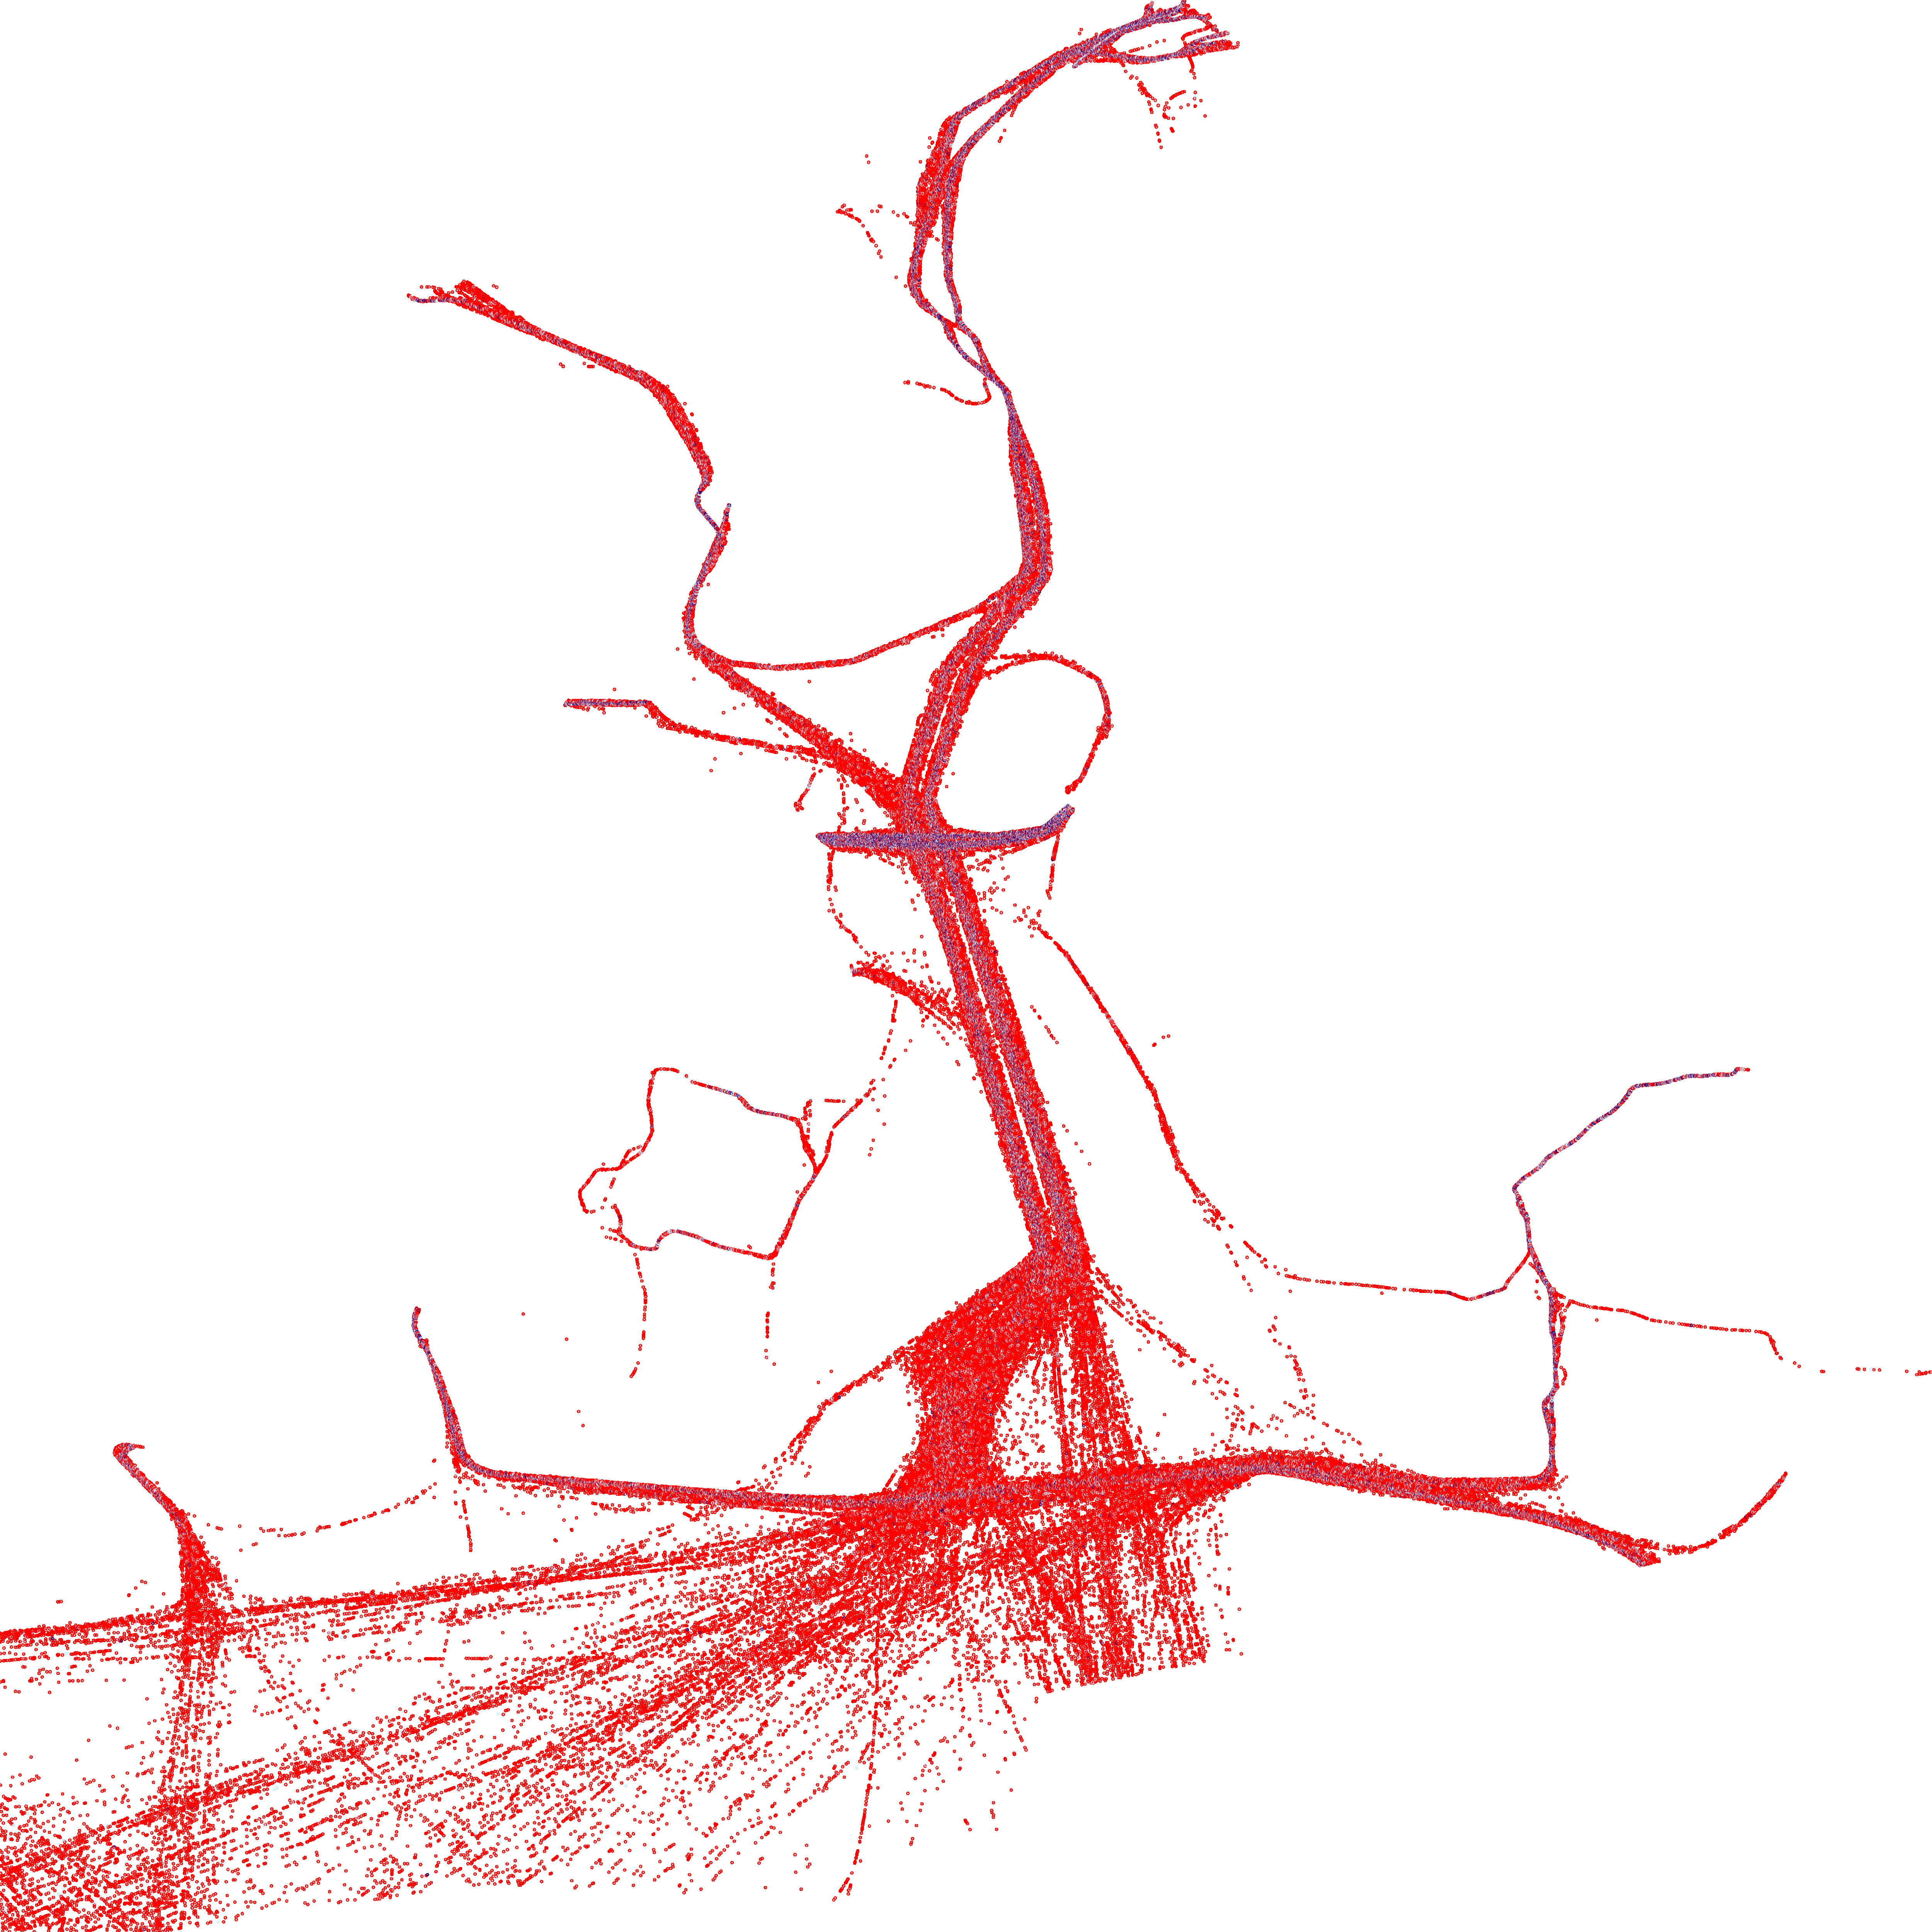

In [10]:
'''
i = 10
mmsi = evaluation_results['mmsi'].iloc[i]
predictions = {evaluation_results['predicted_path'].iloc[i] : 1}
start_node = [evaluation_results['predicted_path'].iloc[i][0]]
trajectory = test_trajectories.get_trajectory(mmsi)
true_path = evaluation_results['true_path'].iloc[i]
map = visualize.map_prediction_and_ground_truth(predictions, start_node, trajectory, true_path, network, 
                                                min_passages=1, opacity=0.2, location=location)
map
'''

In [11]:
evaluation_results

mmsi  \
0   209313000_9_2022-09-17 19:07:12   
0   209535000_0_2022-09-08 09:43:34   
0   209535000_4_2022-09-09 16:33:41   
0   209535000_5_2022-09-14 14:54:06   
0   209535000_5_2022-09-14 14:54:06   
..                              ...   
0   477195900_2_2022-09-04 18:17:41   
0   538009723_1_2022-09-11 01:55:38   
0   538009723_1_2022-09-11 01:55:38   
0   538009723_4_2022-09-11 14:22:56   
0   538009723_4_2022-09-11 14:22:56   

                                            true_path  \
0   (445, 444, 430, 421, 431, 437, 436, 442, 441, ...   
0   (491, 334, 330, 333, 336, 9, 160, 158, 15, 183...   
0   (527, 537, 536, 533, 500, 502, 530, 528, 556, ...   
0   (418, 392, 382, 448, 460, 456, 457, 428, 429, ...   
0   (333, 336, 9, 160, 158, 15, 183, 184, 185, 186...   
..                                                ...   
0   (528, 661, 658, 656, 651, 635, 655, 652, 648, ...   
0   (418, 392, 382, 448, 457, 428, 429, 443, 449, ...   
0   (161, 160, 158, 15, 184, 185, 186, 16, 167, 16...   
0   (527, 526, 537, 536, 533, 499, 502, 530, 528, ...   
0   (640, 636, 637, 638, 634, 619, 617, 618, 644, ...   

                                       predicted_path  \
0   (445, 444, 430, 421, 431, 447, 446, 437, 436, ...   
0   (491, 497, 10, 294, 279, 281, 280, 306, 305, 2...   
0   (527, 526, 537, 536, 533, 515, 504, 505, 266, ...   
0   (418, 403, 392, 382, 448, 460, 451, 456, 457, ...   
0   (333, 336, 9, 161, 160, 156, 15, 183, 184, 185...   
..                                                ...   
0   (528, 556, 657, 656, 651, 635, 654, 655, 652, ...   
0   (418, 403, 392, 382, 448, 460, 451, 456, 457, ...   
0   (161, 160, 156, 15, 183, 184, 185, 186, 16, 16...   
0   (527, 526, 537, 536, 533, 515, 500, 499, 502, ...   
0   (640, 636, 637, 638, 634, 619, 620, 618, 644, ...   

                                            distances         SSPD  \
0   [0.0, 1.2826370862108567e-10, 8.55186411519628...   298.192131   
0   [0.0, 101.03150541374882, 202.06301082732554, ...  6370.178427   
0   [0.0, 20.785795151443114, 41.57159030300152, 6...  8643.131070   
0   [0.0, 20.122613650811257, 40.24522730151142, 6...   277.826866   
0   [0.0, 5.278853973521908e-11, 8.505655816785855...     7.437640   
..                                                ...          ...   
0   [0.0, 32.30390633787101, 64.6078126753912, 96....   149.507209   
0   [0.0, 24.9874213466664, 49.97484269305431, 74....   878.588767   
0   [0.0, 3.299230615407377e-11, 4.952373254488907...     8.990199   
0   [0.0, 4.22617804143551e-12, 8.45235608287102e-...   548.460134   
0   [0.0, 8.088035517372906e-11, 3.738575476206840...     1.863448   

    choice_accuracy  
0               0.7  
0               0.0  
0               0.2  
0               0.6  
0               0.6  
..              ...  
0               0.5  
0               0.4  
0               0.6  
0               0.6  
0               0.8  

[820 rows x 6 columns]

In [12]:
from make_trajectories_from_AIS import add_ship_metadata

# add original mmsi column back to dataframe
evaluation_results.rename(columns={'mmsi':'id'}, inplace=True)
evaluation_results['mmsi'] = evaluation_results['id'].str[:9].astype(int)

# add metadata to each mmsi
meta_file = '../../data/external/seilas-2022.csv'
evaluation_results_meta = add_ship_metadata(meta_file, evaluation_results)

Geopandas has version 0.13.2
Movingpandas has version 0.17.1
Ship metadata has   4142 unique MMSIs
AIS raw data has    125 unique MMSIs
Overlap:            125 MMSIs


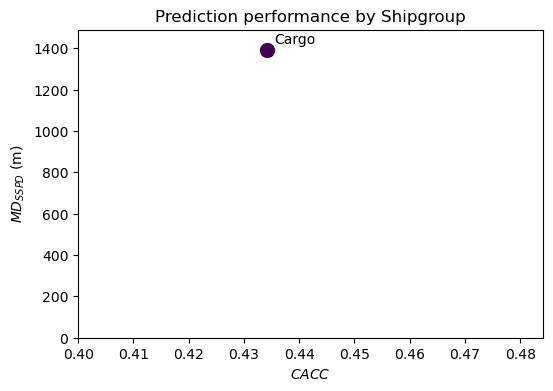

In [13]:
import matplotlib.pyplot as plt

# get choice accuracy and SSPD by shipgroup
sspd_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['SSPD'].mean()
cacc_by_group = evaluation_results_meta.groupby(['skipsgruppe'])['choice_accuracy'].mean()

x = cacc_by_group.values
y = sspd_by_group.values
categories = sspd_by_group.index

fig, ax = plt.subplots(figsize=[6, 4])

# Scatter plot with different colors and markers for each category
scatter = ax.scatter(x, y, c=range(len(categories)), cmap='viridis', marker='o', s=100)

# Annotate each point with the ship category name
for i, category in enumerate(categories):
    ax.annotate(category, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='left')

max_x_value = max(x)
max_y_value = max(y)
ax.set_xlim(0.4, max_x_value+0.05)
ax.set_ylim(0, max_y_value+100)

ax.set_xlabel('$CACC$')
ax.set_ylabel('$MD_{SSPD}$ (m)')
plt.title('Prediction performance by Shipgroup')
plt.savefig('prediction_performance_by_ship_category_tromso_Gretel_3nodes.pdf')

plt.show()

In [14]:
# Count occurrences of each index
index_counts = evaluation_results_meta['skipsgruppe'].value_counts()

# Display the result
print(index_counts)

skipsgruppe
Cargo    820
Name: count, dtype: int64
